In [100]:
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import umap
%matplotlib inline

### Multi task plotting

In [295]:
# Read in all cancer data
cancers_df = pd.read_csv('../../Data/Cancers.csv').iloc[:,1:]

In [321]:
model_paths = sorted(glob.glob('../tensorboard_runs/MT_ST_compare*T/*'))
if type(model_paths) != list:
    model_paths = [model_paths]
model_paths.append('../tensorboard_runs/MT_ST_compare_MT/GEO_GCN_Decagon_feats_')
all_results = {}
all_results['f1s'] = pd.DataFrame()
all_results['recalls'] = pd.DataFrame()

for f in model_paths:
    try:
        dict_ = np.load(f+'/results.npy', allow_pickle = True).item() 
        df = {}
        df['f1s'] = {}
        df['recalls'] = {}
        for k,v_dict in dict_.items():
            df['f1s'][k] = []
            df['recalls'][k] = []
            for v in v_dict:
                df['f1s'][k].append(v['f1'])
                df['recalls'][k].append(v['recall'])
        
        df['f1s'] = pd.DataFrame(df['f1s'])
        df['f1s'] = df['f1s'].melt(var_name=['Disease'], value_name='F1')
        df['f1s']['model'] = ''.join(f.split('/')[-2:]).strip('HO_')
        
        df['recalls'] = pd.DataFrame(df['recalls'])
        df['recalls'] = df['recalls'].melt(var_name=['Disease'], value_name='Recall')
        df['recalls']['model'] = ''.join(f.split('/')[-2:]).strip('HO_')
                     
        all_results['f1s'] = all_results['f1s'].append(df['f1s'])
        all_results['recalls'] = all_results['recalls'].append(df['recalls'])
    except:
        pass

### Regular bar plot

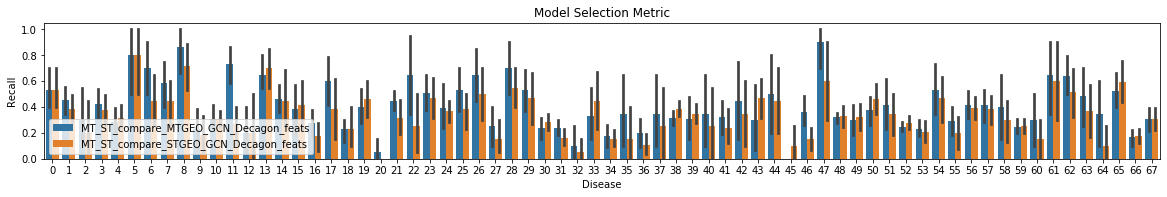

In [5]:
plt.figure(figsize=[20,2.5])
ax = sns.barplot(x='Disease', y='Recall', data=all_results['recalls'], hue='model')
plt.title('Model Selection Metric')
plt.legend(loc=3)

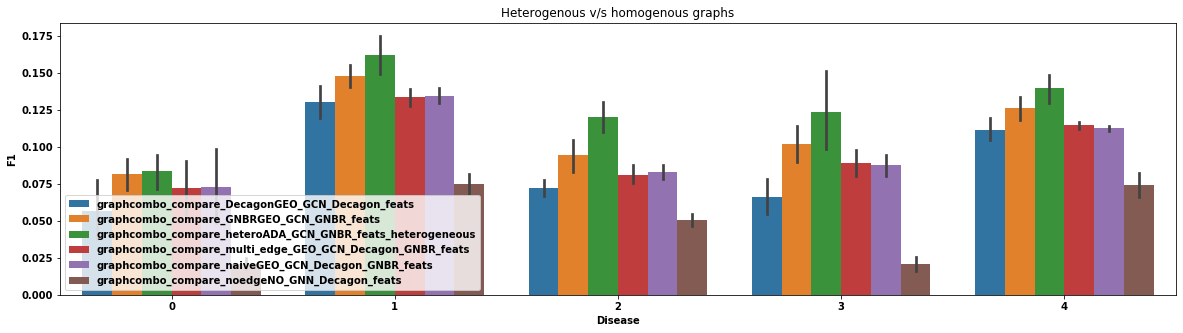

In [66]:
plt.figure(figsize=[20,5])
ax = sns.barplot(x='Disease', y='F1', data=all_results['f1s'], hue='model')
plt.title('Heterogenous v/s homogenous graphs')
plt.legend(loc=3)
plt.legend(['Decagon','GNBR',''])

### Disease class comparison

In [251]:
## Adds disease class labels to the results df
def add_class_labels(results):
    all_diseases = pd.read_csv('../all_diseases.csv').iloc[:,1:]
    all_sums = all_diseases.sum()
    all_diseases = all_diseases.columns
    
    disease_classes = pd.read_csv('../../Data/bio-pathways-diseaseclasses.csv')
    ordered_classes, ordered_count = [], []
    for it, disease in enumerate(all_diseases):
        if disease in disease_classes['Disease Name'].values:
            ordered_classes.append(disease_classes[disease_classes['Disease Name']==disease]['Disease Class'].iloc[0])
        else:
            ordered_classes.append('No Class')
        ordered_count.append(all_sums[it])

    classed_diseases = pd.DataFrame({'Disease_Name':all_diseases,
                                     'Disease_Class':ordered_classes,
                                     'Disease_Count':ordered_count})
    classed_diseases = classed_diseases.reset_index()
    return results.merge(classed_diseases, left_on='Disease', right_on='index')

# Returns subset
def subset(df,col,label):
    return df[df[col]==label]

# Returns mean over grouped subsets
def g_mean(df,label):
    return df.groupby(label).mean()

def post_process(res = all_results):
    mean = g_mean(res,'Disease')
    mean = add_class_labels(mean)
    meanl = mean[mean['Disease_Class']!='No Class']

    # for dist plot
    res = res.fillna(value=0)
    res = add_class_labels(res)
    
    return mean, res

def order_recalls(mean, order):
    return mean[mean.Disease_Class.isin(order)]

In [302]:
# This cell is well defined for single task but NOT for MT
mean_recalls = []
all_res = []

# Rearranging model names
models = all_results['recalls'].model.unique()

for i in models:
    subset = all_results['recalls'][all_results['recalls'].model==i]
    a,c = post_process(subset)
    mean_recalls.append(a)
    all_res.append(c)
    
classes_for_plots=mean_recalls[0].Disease_Class.value_counts().index[:14]
classes_fot_plots=[c for c in classes_for_plots if c != 'endocrine system disease']
mean_recalls = [order_recalls(m, classes_fot_plots) for m in mean_recalls]

mean_recalls_df = pd.concat(mean_recalls)
mean_recalls_df['Model']='Single Task'

In [317]:
## For MTL only
MTL_mean_recalls = []
name_correct = {'cardio':'cardiovascular system disease',
            'endocrine':'endocrine system disease',
            'gastro':'gastrointestinal system disease',
            'immune':'immune system disease',
            'metabolic':'inherited metabolic disorder',
            'monogenic':'monogenic disease',
            'musculoskeletal':'musculoskeletal system disease',
            'neuro': 'nervous system disease',
            'respiratory': 'respiratory system disease',
            'urinary': 'urinary system disease', 
            'viral': 'viral infectious disease',
            'MT':'cancer'}

for m in all_results['recalls']['model'].unique():
    subset = all_results['recalls'][all_results['recalls']['model']==m]
    if m.split('_')[0] == 'endocrine':
        continue
    MTL_mean_recalls.append(subset.groupby('Disease').mean())
    MTL_mean_recalls[-1]['Disease_Class']=name_correct[m.split('_')[0]]
    MTL_mean_recalls[-1]['Model']='MTL'
    
MTL_mean_recalls_df = pd.concat(MTL_mean_recalls)
MTL_mean_recalls_df['Model']='Multi Task'

In [306]:
# Set plot parameters
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 25

In [318]:
## Create common plotting df
plot_df = pd.concat([MTL_mean_recalls_df,mean_recalls_df.loc[:,['Recall','Disease_Class','Model']]])

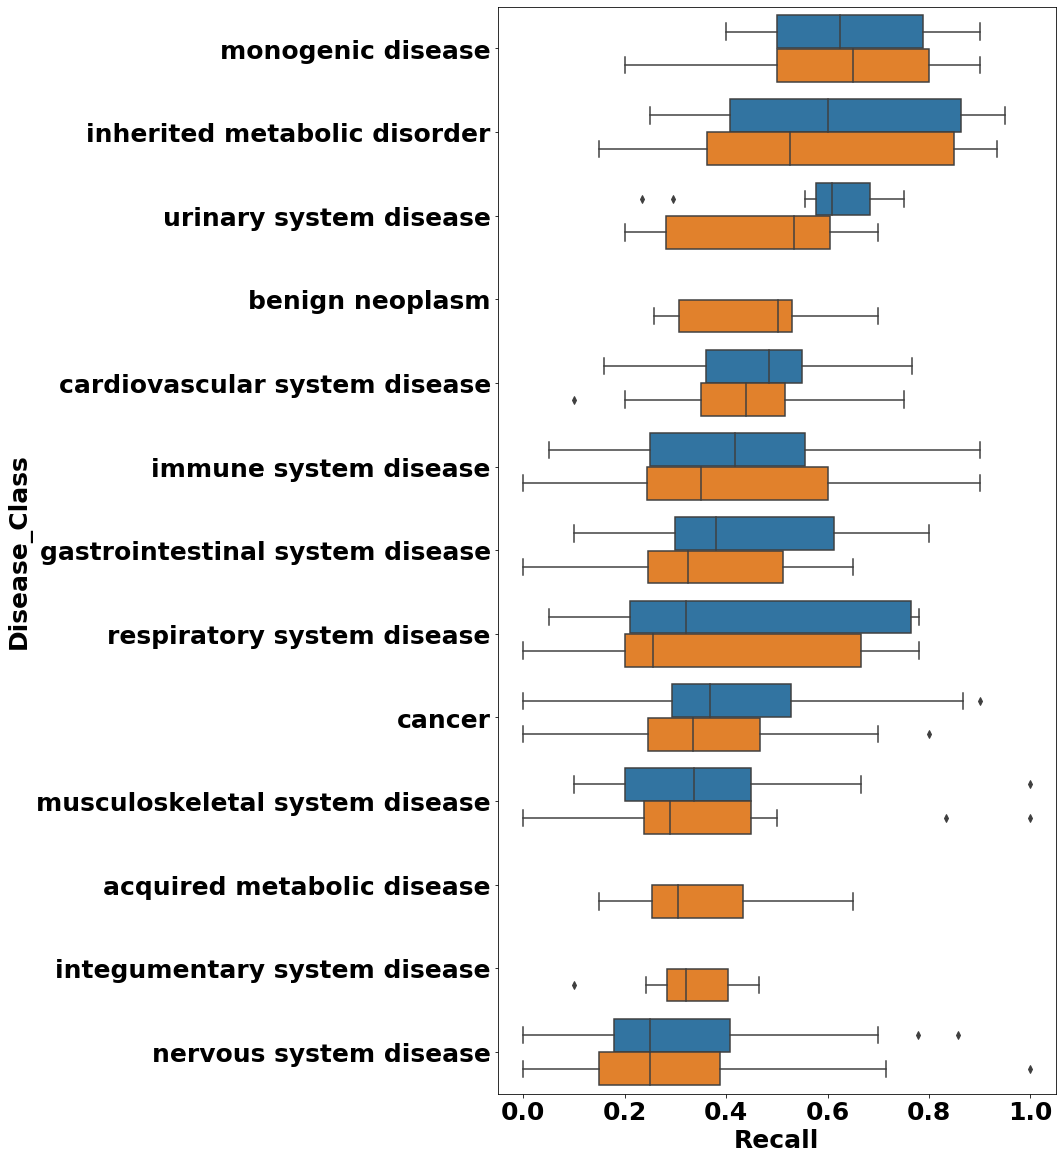

In [320]:
## Create box plot
recall_order = [r for r in recall_order if r != 'endocrine system disease']

fig = plt.figure(figsize=[10,20])
ax = sns.boxplot(data=plot_df, x='Recall', y='Disease_Class', orient='h', 
                order=recall_order, hue='Model')
ax.get_legend().remove()

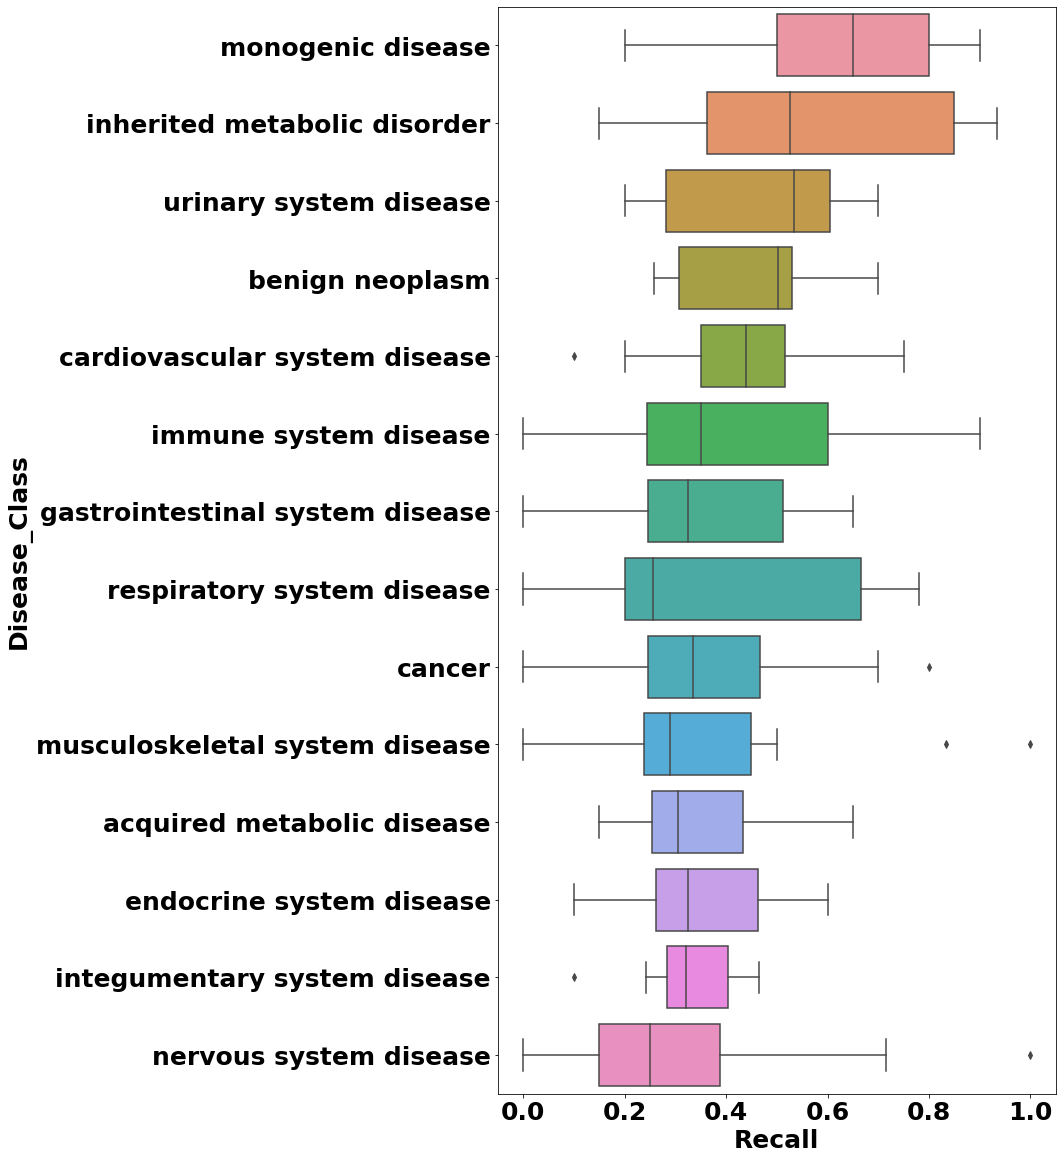

In [61]:
## Create box plot
fig = plt.figure(figsize=[10,20])
_ = sns.boxplot(data=mean_recall, x='Recall', y='Disease_Class', orient='h', order=recall_order)

In [ ]:
sns.barplot(data=mean_recall, x='Diseas', y='Disease_Class', orient='h')

Text(0, 0.5, 'Disease nodes')

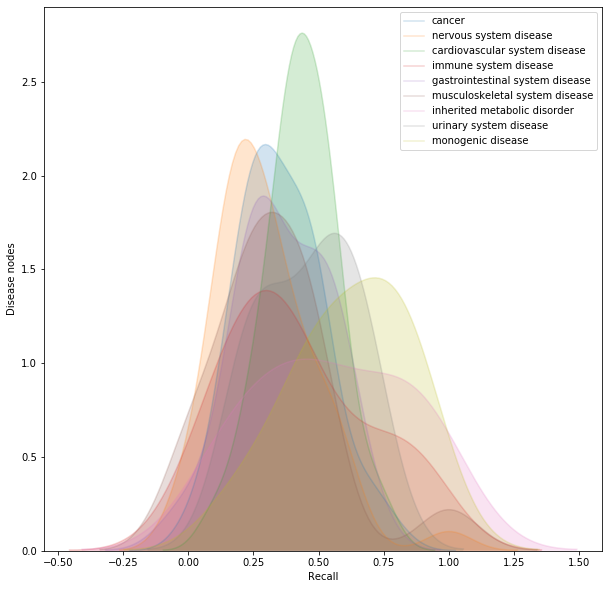

In [273]:
## Picking the right set of disease categories
class_list = all_results['recalls'].Disease_Class.value_counts()[1:10].index

## Plotting distribution
fig = plt.figure(figsize=[10,10])
for dis in class_list:
    x = subset(all_results['recalls'], 'Disease_Class',dis)
    sns.kdeplot(g_mean(x,'Disease').Recall, shade=True,
                alpha=0.2,
                shade_lowest=False)
plt.legend(class_list)
plt.xlabel('Recall')
plt.ylabel('Disease nodes')

### For MT-ST comparison

In [322]:
MT_df_ = all_results['recalls'][all_results['recalls']['model']=='MT_ST_compare_MTGEO_GCN_Decagon_feats']
ST_df_ = all_results['recalls'][all_results['recalls']['model']=='MT_ST_compare_STGEO_GCN_Decagon_feats']

MT = MT_df_.groupby('Disease').mean()
ST = ST_df_.groupby('Disease').mean()

In [323]:
plot_df = MT-ST
plot_df['size']=cancers_df.sum().values
plot_df=plot_df.reset_index()
plot_df = plot_df.sort_values('size')
plot_df['Order']=list(range(len(plot_df)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 0, 'Dataset size')

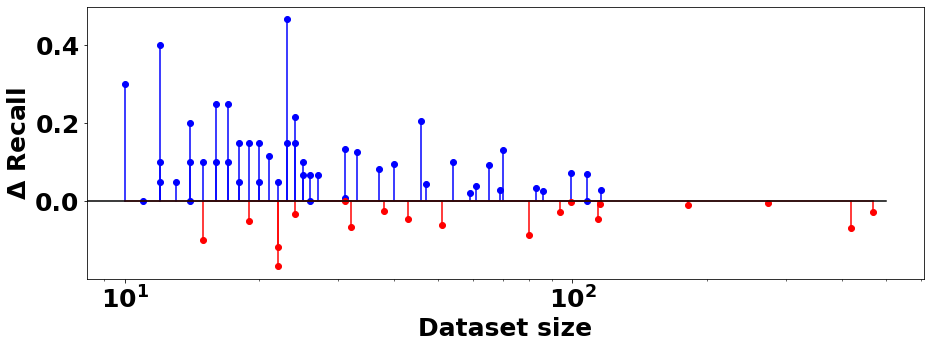

In [325]:
plt.figure(figsize=[15,5])
pos_df = plot_df[plot_df['Recall']>=0]
neg_df = plot_df[plot_df['Recall']<0]

(markers, _, _) = plt.stem(pos_df['size'],pos_df['Recall'], 'blue')
plt.setp(markers, markeredgecolor="blue", markerfacecolor='blue')

(markers, _, _) = plt.stem(neg_df['size'],neg_df['Recall'], 'red')
plt.setp(markers, markeredgecolor="red", markerfacecolor='red')

plt.plot([0,500],[0,0], 'black')
plt.ylabel(r'$\Delta$ Recall')
plt.xscale('log')
plt.xlabel('Dataset size')
#plt.legend(loc=2)

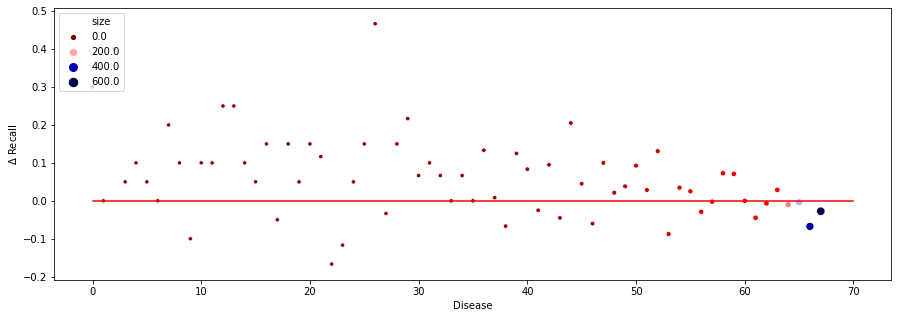

In [98]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='Order',y='Recall',size='size', hue='size',palette='seismic_r',data=plot_df)
plt.plot([0,70],[0,0], 'red')
plt.ylabel(r'$\Delta$ Recall')
plt.xlabel('Disease')
plt.legend(loc=2)

### Comparing UMAPs

In [15]:
all_diseases = pd.read_csv('../all_diseases.csv').iloc[:,1:]

In [28]:
embeddings = [np.load(e) for e in glob.glob('../tensorboard_runs/MT_ST_compare_embed_*/*/node_embeddings.npy')]
umap_embed_0 = umap.UMAP(random_state=42).fit(embeddings[0])
umap_embed_1 = umap.UMAP(random_state=42).fit(embeddings[1])

In [31]:
len(embeddings[1])

19081

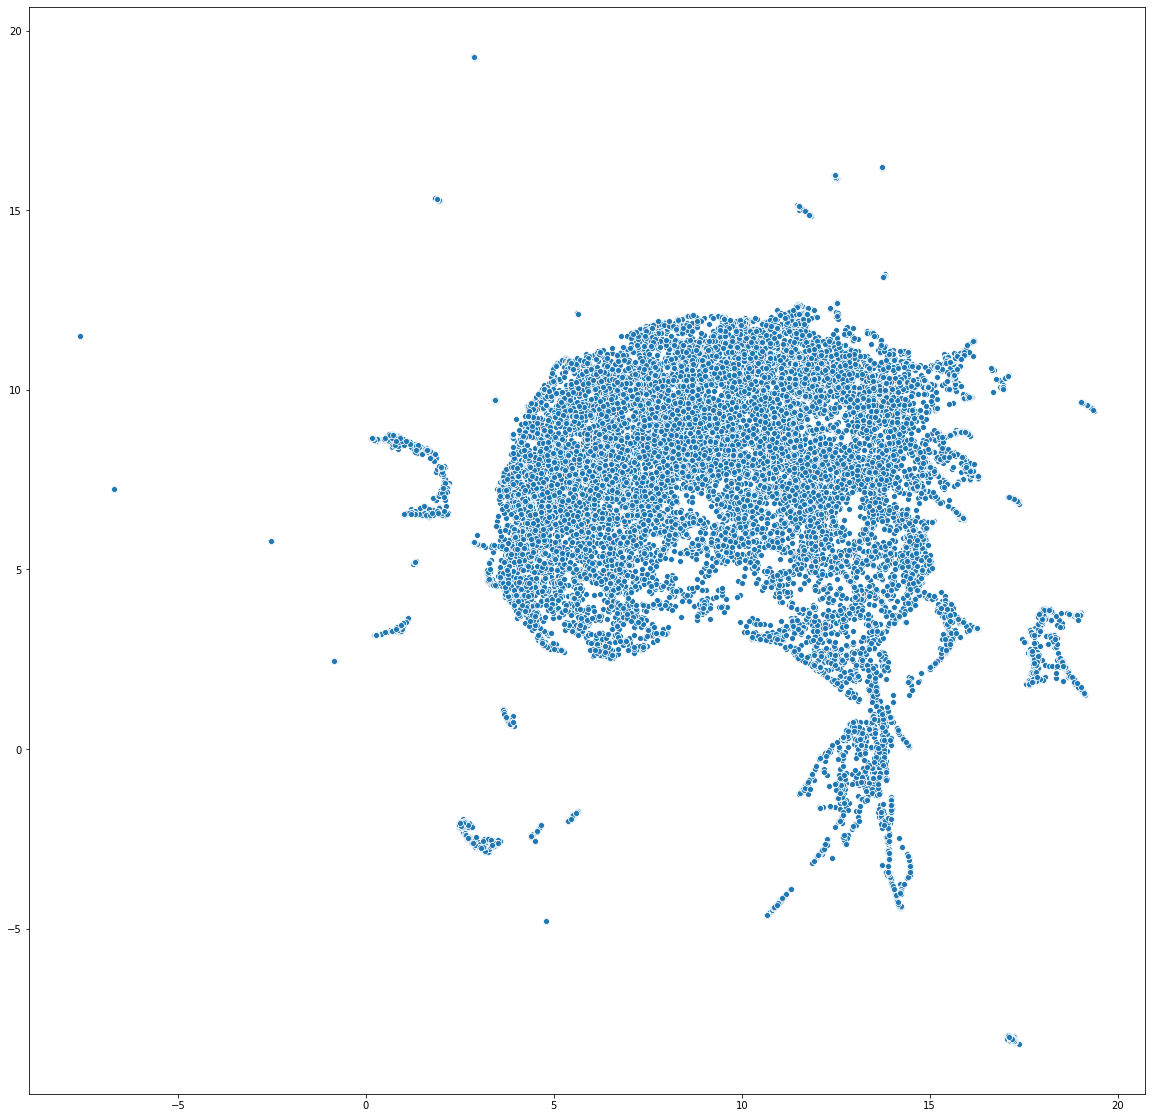

In [32]:
plt.figure(figsize=[20,20])
sns.scatterplot(n_neighbors=umap_embed_0.embedding_[:, 0], umap_embed_0.embedding_[:, 1])

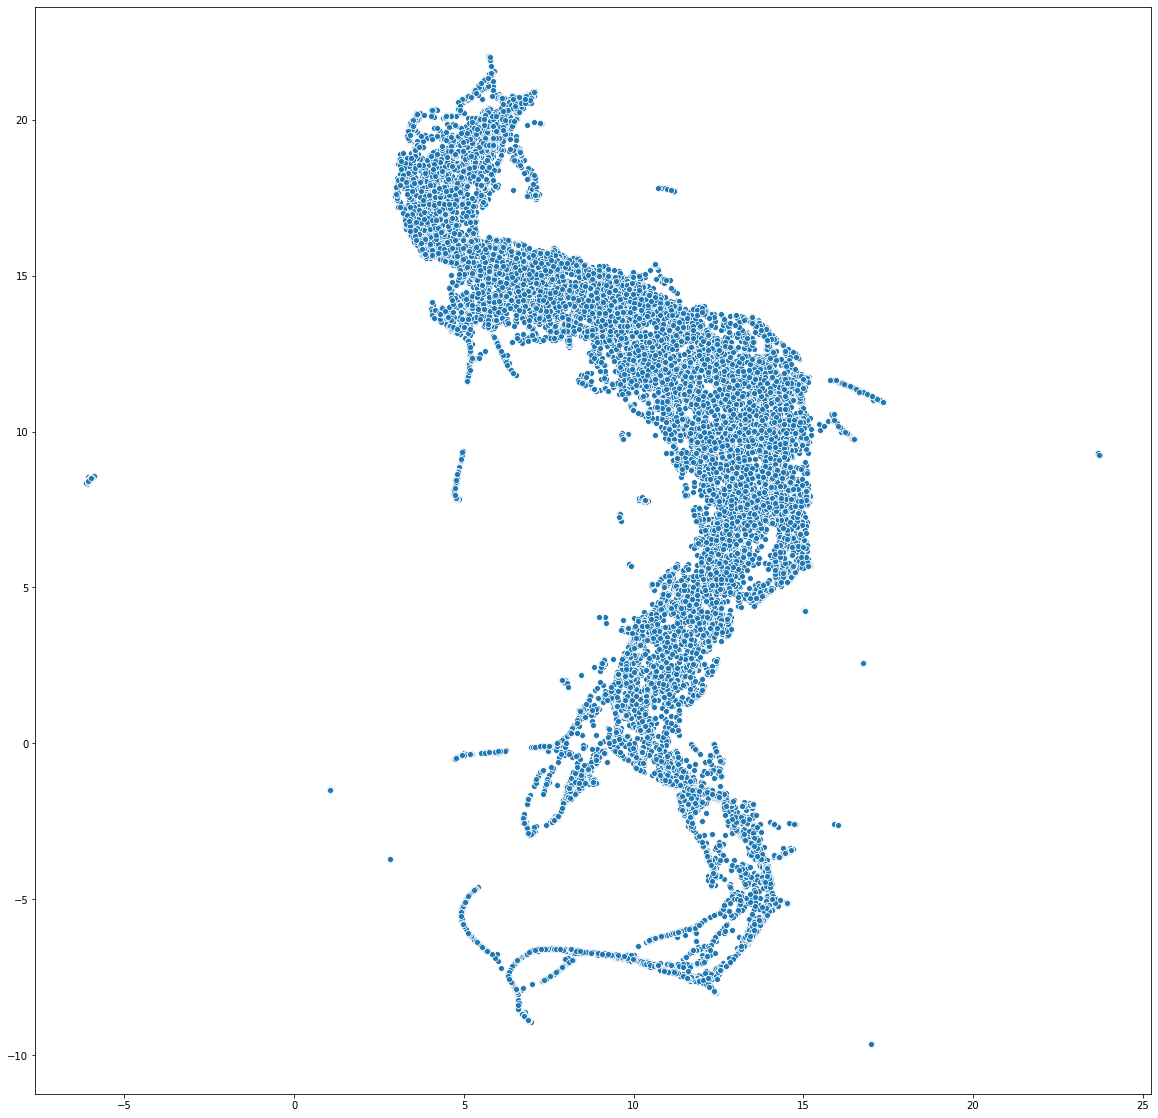

In [33]:
plt.figure(figsize=[20,20])
sns.scatterplot(umap_embed_1.embedding_[:, 0], umap_embed_1.embedding_[:, 1])

In [26]:
len(all_diseases)

19678

### Previous model plots

In [49]:
special_names = ['5000epoch','single_task_rerun']
special_models = [['..'+i.strip('results.npy') for 
                  i in glob.glob('../tensorboard_runs/*'+s+'/*.npy')][0] for s in special_names]

In [50]:
special_models

['../tensorboard_runs/5000epoch/', '../tensorboard_runs/single_task_rerun/']

In [3]:
special_names_2 = ['LR001', 'LR0001', 'LR0001_2k']
special_models.extend([['..'+i.strip('results.npy') for 
                  i in glob.glob('../tensorboard_runs/single_task/*'+s+'/*.npy')][0] for s in special_names_2])
special_names.extend(special_names_2)

In [51]:
req_len = 68
models = []
#models = ['..'+i.strip('results.npy')
#             for i in glob.glob('../tensorboard_runs/single_task/04-05*/*.npy')]
models.extend(special_models)

run_dicts = [np.load(i+'results.npy', allow_pickle=True).item() 
             for i in models]

idx = [it for it,r in enumerate(run_dicts) if len(r)==req_len or len(r)==38]
models=np.array(models)[idx]
run_dicts = np.array(run_dicts)[idx]

model_names = [glob.glob(i+'*_*')[0].split('/')[-1] 
             for i in models]

for it in range(-1,-3,-1):
    model_names[it] = model_names[it]+special_names[it]

In [52]:
f1s = {}
recalls = {}
#for i in range(len(run_dicts[0])):
for i in range(38):
    f1s[i] = []
    recalls[i] = []

for dict_ in run_dicts:
    for k,v in dict_.items():
        if k == 38:
            break
        try:
            f1s[k].append(v[0]['f1'])
            recalls[k].append(v[0]['recall'])
        except:
            f1s[k].append(v['f1'])
            recalls[k].append(v['recall'])

### Comparing results across models

In [53]:
def plot_scatter(df, baseline, ticks, label=None, title=None):
    df['name'] = ticks
    df = df.sort_values('name')
    ticks = df['name'].values
    df = df.drop('name',1)
    
    plt.scatter(x=range(len(df)),y=df.median(1),color='b')
    plt.scatter(x=range(len(df)),y=df.mean(1),color='g')
    plt.plot([0,len(df)],[baseline,baseline],'r')
    plt.ylim([0,0.8])
    plt.xlabel('Models')
    plt.ylabel(label)
    plt.title(title)
    
    plt.xticks(list(range(len(ticks))), ticks, rotation=90)
    plt.legend(['Aggarwal baseline','Median','Mean'])
    

Text(0, 0.5, 'Recall')

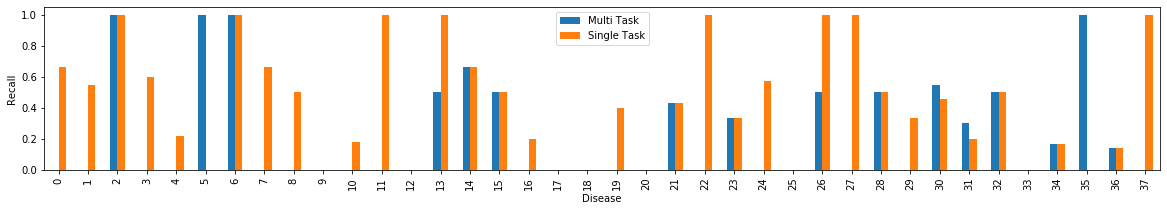

In [56]:
pd.DataFrame(recalls).T.plot.bar()
fig = plt.gcf()
fig.set_size_inches(20, 3)
plt.legend(['Multi Task','Single Task'])
plt.xlabel('Disease')
plt.ylabel('Recall')

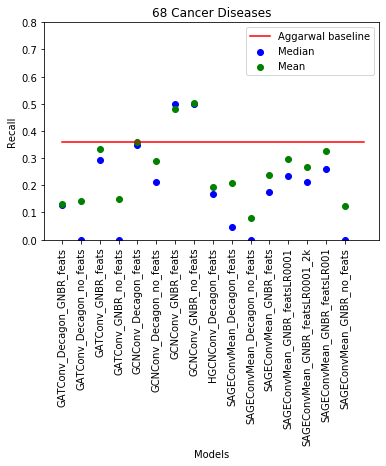

In [40]:
plot_scatter(pd.DataFrame(recalls),0.36, model_names, label='Recall', title='68 Cancer Diseases')

### Creating multi dimensional edges for multi graph

In [190]:
D = pd.read_csv('../../dataset_collection/PP-Decagon_ppi.csv', header=None)
G = pd.read_csv('../../dataset_collection/GNBR-edgelist.csv', header=None)

# This is the naive edge concatenation
DG = D.append(G)
DG = DG.drop_duplicates()
DG.to_csv('../../dataset_collection/Decagon_GNBR_2.csv', header=False, index=False)

In [75]:
# Create multi-dimensional edge file
D['edge_feat_1']=1
G['edge_feat_2']=1

# This is the multi edge implementation
DG_ = D.merge(G, on=[0,1], how='outer')
DG_ = DG_.fillna(value=0)
DG_.iloc[:,2:].to_csv('../../dataset_collection/Decagon_GNBR_MultiEdges.csv', header=False, index=False)


In [76]:
edge_attr = pd.read_csv('../../dataset_collection/Decagon_GNBR_MultiEdges.csv', header=None)